In [9]:
# Extract features
import os, shutil
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16


datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32
base_dir = '/home/jovyan/data/img'
train_dir = os.path.join(base_dir,'train')
dev_dir = os.path.join(base_dir,'dev')
img_width = 50
img_height = 50
batch_size = 200
conv_base = VGG16(weights='imagenet', include_top=False)

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count))
    # Preprocess data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(img_width,img_height),
                                            batch_size = batch_size,
                                            class_mode='binary')
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
 
train_size = 8500  
dev_size = 501  


In [10]:
#train_features, train_labels = extract_features(train_dir, train_size)  # Agree with our small dataset size
#validation_features, validation_labels = extract_features(dev_dir, dev_size)

#np.savez('VGG16_data.npz', train_features=train_features, train_labels=train_labels, 
#         validation_features= validation_features, validation_labels= validation_labels)



In [11]:
VGG16_data = np.load("VGG16_data.npz")
train_features = VGG16_data['train_features']
train_labels = VGG16_data['train_labels']
validation_features = VGG16_data['validation_features']
validation_labels = VGG16_data['validation_labels']

In [21]:
train_features.shape[1:]

(7, 7, 512)

In [43]:
# Define model
from keras import models
from keras import layers
from keras import optimizers
from keras.callbacks import ModelCheckpoint 
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf
from sklearn.metrics import roc_auc_score

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

# Function to create model, required for KerasClassifier
def create_model(learn_rate=0.01):
    # create model
    model = models.Sequential()
    model.add(layers.GlobalAveragePooling2D(input_shape=train_features.shape[1:]))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(1, activation='softmax'))
    model.summary()
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=learn_rate), metrics=["accuracy"])
    return model

model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=10, verbose=0)

learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(learn_rate=learn_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)
grid_result = grid.fit(train_features, train_labels)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Model: "sequential_363"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_362 (None, 512)               0         
_________________________________________________________________
dropout_286 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_361 (Dense)            (None, 1)                 513       
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_364"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_363 (None, 512)               0         
_________________________________________________________________
dropout_287 (Dropout)        (None, 512)               0         
______________________________

Model: "sequential_374"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_373 (None, 512)               0         
_________________________________________________________________
dropout_297 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_372 (Dense)            (None, 1)                 513       
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_375"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_374 (None, 512)               0         
_________________________________________________________________
dropout_298 (Dropout)        (None, 512)               0         
______________________________

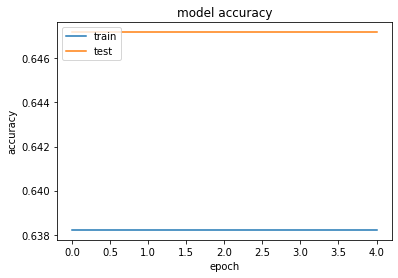

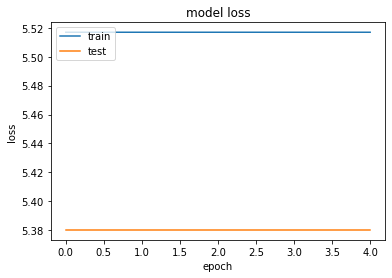

In [16]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [92]:
model.load_weights('saved_models/weights.best.VGG16.hdf5')

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# get index of predicted dog breed for each image in test set
validation_pred = model.predict(validation_features).ravel()
fpr_dev_keras, tpr_dev_keras, thresholds_dev_keras = roc_curve(validation_labels, validation_pred)
auc_dev_keras = auc(fpr_dev_keras, tpr_dev_keras)
print(auc_dev_keras)

0.5000717131474104


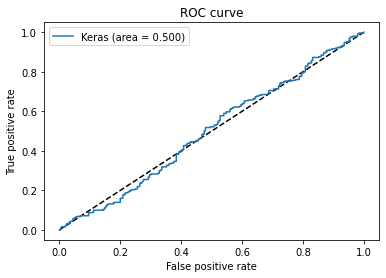

In [93]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_dev_keras, tpr_dev_keras, label='Keras (area = {:.3f})'.format(auc_dev_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()